# How can we reduce the error in Zillow's Zestimate?

### Paddy Doran and Sean Oslin
November 12, 2019

# Project planning phase

### Project goals

1. Determine what factor(s) is driving the difference in Zestimate to sales price (i.e 'logerror').

2. Build an improved model to predict the logerror.

## Deliverables

## Acquisition, Prep, and Initial Exploration

### Data source
All data originated with the Zillow database.

### Python libraries used for analysis

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Python programming for this analysis imported from associated text documents¶

In [2]:
import env
df = pd.read_csv("zillow.csv")
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,12177905,2288172,NaN,NaN,NaN,3,4,NaN,8.0,3,...,108918.0,145143,2016,36225,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
1,10887214,1970746,1.0,NaN,NaN,3,3,NaN,8.0,3,...,73681.0,119407,2016,45726,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01
2,12095076,781532,1.0,NaN,NaN,3,4,NaN,9.0,3,...,276684.0,773303,2016,496619,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01
3,12069064,870991,NaN,NaN,NaN,1,2,NaN,5.0,1,...,18890.0,218552,2016,199662,2366.08,NaN,NaN,6.037302e+13,0.101723,2017-01-01
4,12790562,1246926,NaN,NaN,NaN,3,4,NaN,9.0,3,...,177527.0,220583,2016,43056,3104.19,NaN,NaN,6.037500e+13,-0.040966,2017-01-02


## Data preparation

#### Force 'head' to show all columns

In [3]:
pd.set_option('display.max_columns', None) 

#### Remove duplicate columns

In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [5]:
df = remove_dup_col(df)

#### Calculate the number and percent of missing values for each attribute

In [6]:
# def df2(df):
#     num_rows_missing = df.isna().sum()
#     pct_rows_missing = num_rows_missing/len(df)*100
#     df_sum = pd.DataFrame()
#     df_sum['num_rows_missing'] = num_rows_missing
#     df_sum['pct_rows_missing'] = pct_rows_missing
#     return df_sum

In [7]:
# df2(df)

#### Delete rows and columns with excessing missing values

In [8]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [9]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

#### Drop unneeded columns

In [10]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [11]:
df = drop_col(df)

### Manage missing values

For land square feet, impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x-variable and the output/y-variable is the estimated land square feet.

In [12]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

In [13]:
# Use y when we have y, if y is NaN, use yhat
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

In [14]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

In [15]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

In [16]:
# use y when we have y, if y is NaN, use yhat
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

#### Drop rows with no 'yearbuilt' date

In [17]:
df.fillna(value=pd.np.nan, inplace=True)

In [18]:
df = df.dropna()

In [19]:
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

In [20]:
df = drop_col2(df)

#### Adjust data types

In [21]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

#### Manage outliers

Upper outliers

In [22]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [23]:
new_df = add_upper_outlier_columns(df, k = 4.0)
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())
    new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]
    new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
    new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
    


~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

Lower outliers

In [24]:
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1- k * iqr
    return s.apply(lambda x: x if x < lower_bound else 0)

def add_lower_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_lower_outliers(df[col], k)
                     for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_lower_outliers(df3[col], k)

    return df

add_lower_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000


#### Drop outlier columns

In [25]:
def drop_col(new_df):
    new_df = new_df.drop(columns = [
           'parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
           'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
           'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
           'heatingorsystemtypeid_outliers', 'latitude_outliers',
           'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
           'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
           'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
           'logerror_outliers', 'propertyzoningdesc', 'buildingqualitytypeid', 'heatingorsystemtypeid'])
    return new_df

In [26]:
new_df = drop_col(new_df)

In [27]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)

#### Encode the bathroom and bedroom counts

In [28]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [29]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')

In [30]:
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)

In [31]:
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')

In [32]:
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)

In [33]:
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

In [34]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [35]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [36]:
train_scaled.head()

,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt
0,2.446433,-0.214909,2.727203,1.736769,0.966601
1,-0.036957,-0.183526,-0.838683,-0.162260,0.192868
2,-0.038388,-0.457953,-0.272130,0.765742,1.141300
3,-0.348991,-0.205549,-0.378959,-0.804102,-0.876098
4,-1.154840,-0.356803,-1.011569,-0.594522,-0.293050


In [37]:
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]= train_scaled[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
train.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create dependent variable 'logerror'

In [38]:
# X_train = train.drop(columns ='logerror')
# y_train = train[['logerror']]
# X_test = test.drop(columns ='logerror')
# y_test = test[['logerror']]

In [39]:
# X_train.info()

#### Create clusters

   k           sse
0  1  43738.037848
1  2  22164.072712
2  3  16033.746843
3  4  12201.645569
4  5   8935.899676
5  6   7520.628117
6  7   5566.666269
7  8   3949.735016
8  9   3116.453341


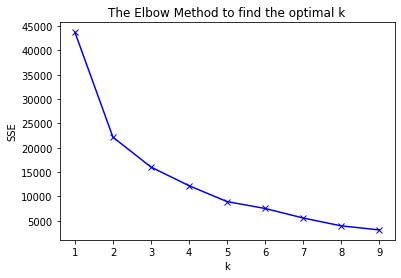

In [40]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [41]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(train[['bathroomcnt', 'bedroomcnt']])
    train['cluster'] = kmeans.predict(train[['bathroomcnt', 'bedroomcnt']])
    return train


In [42]:
train1 = target_cluster(train)
train1.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [43]:
train1.groupby(train1['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.202650e+07,1.503247e+06,1.000000,2.245526,-0.885423,6037.0,3.403103e+07,-1.182222e+08,-0.688729,1.0,1944.291294,-0.274928,-0.431687,-0.234988,-0.009717,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120785,0.512904,0.366311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.181175e+07,1.494799e+06,2.257038,1.958384,-0.444957,6037.0,3.406854e+07,-1.183060e+08,0.046427,1.0,1972.222521,0.725436,0.052310,0.046433,-0.002166,0.000000,0.745655,0.251652,0.002693,0.000000,0.000000,0.000000,0.041616,0.958384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,1.188387e+07,1.508389e+06,2.290772,3.000000,-0.015845,6037.0,3.413490e+07,-1.182355e+08,-0.051172,1.0,1964.945533,-0.100975,-0.041426,-0.029787,0.000331,0.000000,0.709228,0.290772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.193899e+07,1.524584e+06,1.951876,4.075407,0.104814,6037.0,3.413543e+07,-1.182076e+08,-0.237973,1.0,1958.074649,-0.309989,-0.213652,-0.166203,0.001522,0.048124,0.951876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.933687,0.057977,0.007579,0.000758,0.000000,0.000000
4,1.182514e+07,1.491794e+06,3.381755,4.265256,1.458526,6037.0,3.417825e+07,-1.182901e+08,1.042090,1.0,1976.728580,0.006551,0.623008,0.315795,0.009526,0.000000,0.000000,0.698377,0.231149,0.061845,0.007602,0.001027,0.000000,0.000000,0.047052,0.687282,0.227245,0.031642,0.005548,0.001027,0.000205


In [44]:
train1.cluster.value_counts()

0    9547
2    5812
4    4867
1    4085
3    2639
Name: cluster, dtype: int64

In [45]:
train1.groupby('cluster').mean()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.188387e+07,1.508389e+06,2.290772,3.000000,-0.015845,6037.0,3.413490e+07,-1.182355e+08,-0.051172,1.0,1964.945533,-0.100975,-0.041426,-0.029787,0.000331,0.000000,0.709228,0.290772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.181175e+07,1.494799e+06,2.257038,1.958384,-0.444957,6037.0,3.406854e+07,-1.183060e+08,0.046427,1.0,1972.222521,0.725436,0.052310,0.046433,-0.002166,0.000000,0.745655,0.251652,0.002693,0.000000,0.000000,0.000000,0.041616,0.958384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.202650e+07,1.503247e+06,1.000000,2.245526,-0.885423,6037.0,3.403103e+07,-1.182222e+08,-0.688729,1.0,1944.291294,-0.274928,-0.431687,-0.234988,-0.009717,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120785,0.512904,0.366311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.193899e+07,1.524584e+06,1.951876,4.075407,0.104814,6037.0,3.413543e+07,-1.182076e+08,-0.237973,1.0,1958.074649,-0.309989,-0.213652,-0.166203,0.001522,0.048124,0.951876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.933687,0.057977,0.007579,0.000758,0.000000,0.000000
4,1.182514e+07,1.491794e+06,3.381755,4.265256,1.458526,6037.0,3.417825e+07,-1.182901e+08,1.042090,1.0,1976.728580,0.006551,0.623008,0.315795,0.009526,0.000000,0.000000,0.698377,0.231149,0.061845,0.007602,0.001027,0.000000,0.000000,0.047052,0.687282,0.227245,0.031642,0.005548,0.001027,0.000205


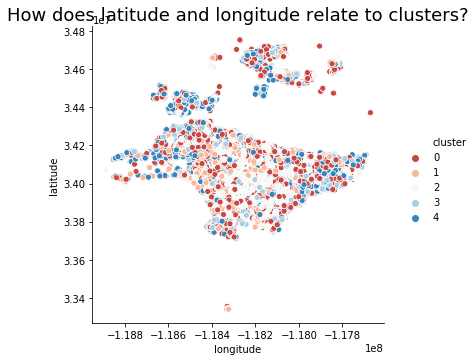

In [50]:
sns.relplot(data=train1, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

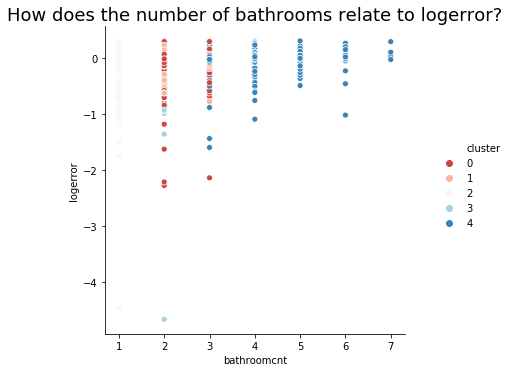

In [49]:

sns.relplot(data=train1, x='bathroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does the number of bathrooms relate to logerror?', fontsize = 18)
plt.show()

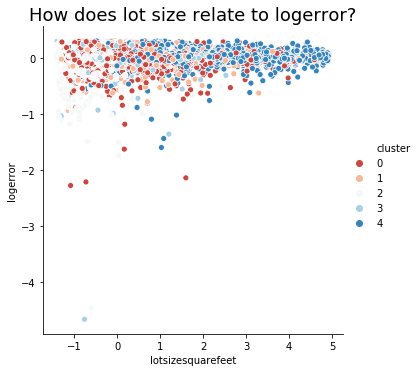

In [51]:
sns.relplot(data=train1, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

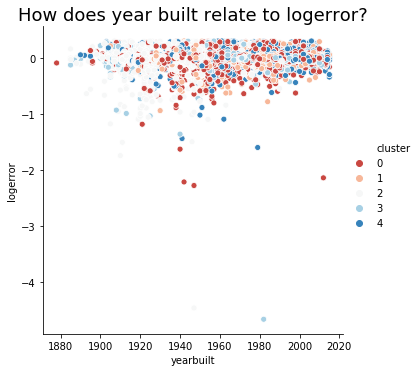

In [52]:
sns.relplot(data=train1, x='yearbuilt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does year built relate to logerror?', fontsize = 18)
plt.show()

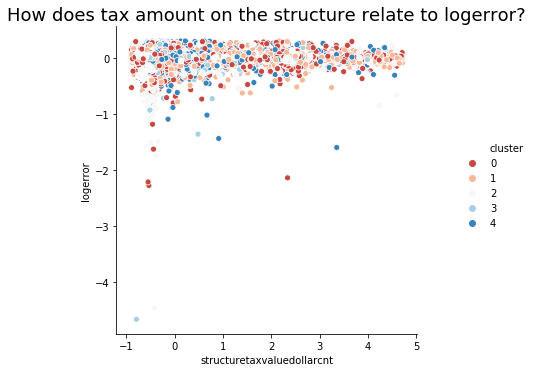

In [53]:
sns.relplot(data=train1, x='structuretaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the structure relate to logerror?', fontsize = 18)
plt.show()

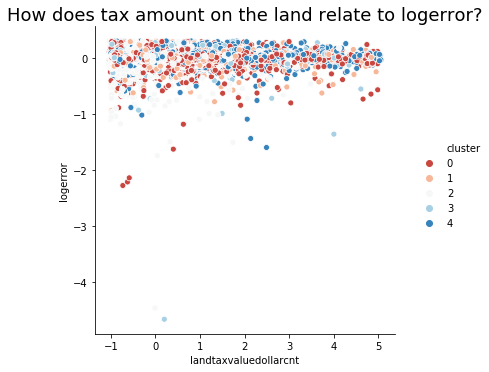

In [54]:
sns.relplot(data=train1, x='landtaxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does tax amount on the land relate to logerror?', fontsize = 18)
plt.show()

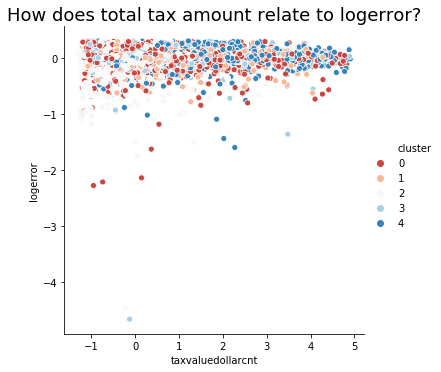

In [55]:
sns.relplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does total tax amount relate to logerror?', fontsize = 18)
plt.show()

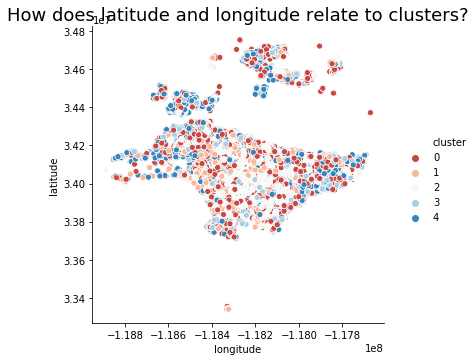

In [56]:
sns.relplot(data=train1, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

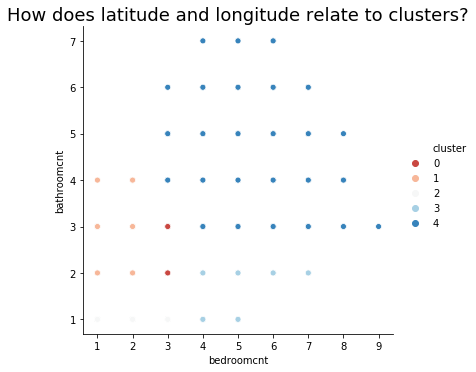

In [57]:
sns.relplot(data=train1, x='bedroomcnt', y='bathroomcnt', hue='cluster', palette = sns.color_palette("RdBu", n_colors=5))
plt.title('How does latitude and longitude relate to clusters?', fontsize = 18)
plt.show()

   k           sse
0  1  2.638030e+15
1  2  1.532507e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363503e+14
5  6  3.547538e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093329e+14


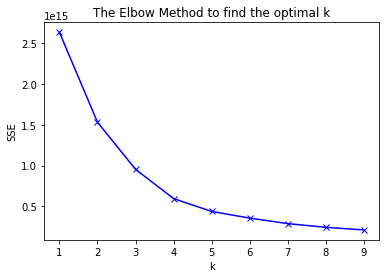

In [58]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['latitude', 'longitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [59]:
def target_cluster(train):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(train[['latitude', 'longitude']])
    train['cluster'] = kmeans.predict(train[['latitude', 'longitude']])
    return train

In [60]:
train2 = target_cluster(train)
train2.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,cluster
0,10745756,135548,4,4,2.446433,6037,34165692,-118770919,2.727203,1,1986,-0.214909,1.736769,0.966601,-0.061629,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,12692106,2961206,2,3,-0.036957,6037,33784829,-118314531,-0.838683,1,1949,-0.183526,-0.162260,0.192868,0.015970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,11839030,1019191,2,4,-0.038388,6037,34042958,-118142629,-0.272130,1,1956,-0.457953,0.765742,1.141300,-0.133100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
3,11280682,853535,2,3,-0.348991,6037,34685575,-118177612,-0.378959,1,1972,-0.205549,-0.804102,-0.876098,-0.043454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,12381829,484421,1,2,-1.154840,6037,33983552,-118118690,-1.011569,1,1942,-0.356803,-0.594522,-0.293050,0.016932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [61]:
train2.groupby(train2['cluster']).mean().sort_values('taxvaluedollarcnt')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.132419e+07,1.508189e+06,2.367110,3.462860,0.293553,6037.0,3.462946e+07,-1.181250e+08,-0.100432,1.0,1986.195792,-0.066187,-0.675232,-0.841315,-0.002267,0.068699,0.536711,0.357664,0.032632,0.004294,0.000000,0.000000,0.003864,0.049377,0.519536,0.349506,0.063976,0.012452,0.001288,0.000000,0.000000
3,1.263892e+07,1.514744e+06,2.130623,3.102077,-0.033256,6037.0,3.406800e+07,-1.179847e+08,-0.105903,1.0,1960.499327,-0.062013,-0.115536,-0.100928,0.004745,0.222239,0.478254,0.257062,0.032581,0.008967,0.000747,0.000149,0.016291,0.210731,0.486175,0.237782,0.041399,0.005829,0.001644,0.000149,0.000000
1,1.222696e+07,1.504553e+06,1.916032,2.821916,-0.256788,6037.0,3.389391e+07,-1.182545e+08,-0.217394,1.0,1955.615440,-0.146134,-0.085074,-0.006705,-0.004271,0.347711,0.429745,0.186541,0.031171,0.004591,0.000121,0.000121,0.044219,0.324393,0.437236,0.159841,0.029117,0.004349,0.000604,0.000242,0.000000
0,1.124217e+07,1.494535e+06,2.370662,3.007148,0.199370,6037.0,3.419997e+07,-1.184614e+08,0.298761,1.0,1965.606754,0.144408,0.292904,0.241185,-0.000300,0.146483,0.447736,0.321765,0.060499,0.019994,0.003211,0.000311,0.040195,0.278255,0.396043,0.215581,0.061328,0.007252,0.001036,0.000207,0.000104


In [62]:
train2.cluster.value_counts()

0    9653
1    8277
3    6691
2    2329
Name: cluster, dtype: int64

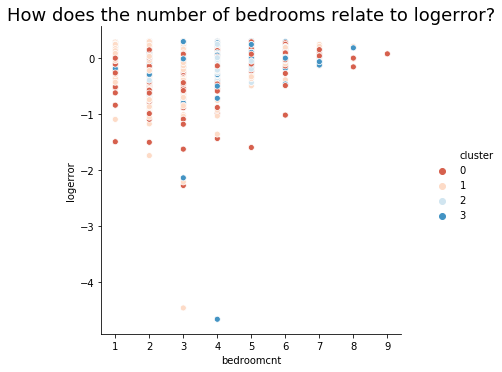

In [64]:
sns.relplot(data=train2, x='bedroomcnt', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does the number of bedrooms relate to logerror?', fontsize = 18)
plt.show()

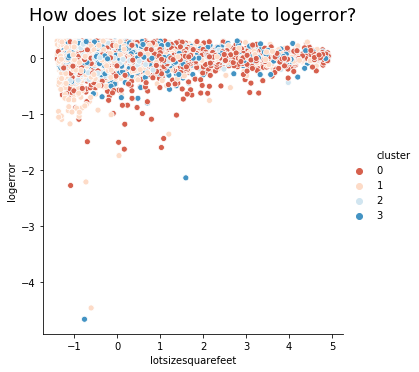

In [65]:
sns.relplot(data=train2, x='lotsizesquarefeet', y='logerror', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))
plt.title('How does lot size relate to logerror?', fontsize = 18)
plt.show()

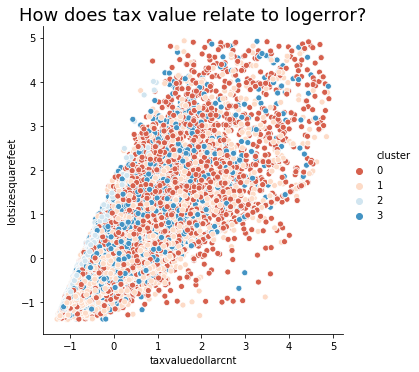

In [66]:
sns.relplot(data=train2, x='taxvaluedollarcnt', y='lotsizesquarefeet', hue='cluster', palette = sns.color_palette("RdBu", n_colors=4))

plt.title('How does tax value relate to logerror?', fontsize = 18)
plt.show()

In [ ]:
# train.drop(columns = (['bathroomcnt', 'bedroomcnt']))
# test.drop(columns = (['bathroomcnt', 'bedroomcnt']))